In [1]:
%config Completer.use_jedi = False # in case your autocomplete does not work

Please read https://arxiv.org/pdf/1610.02391.pdf for the main reference of GRAD-CAM.
GRAD-CAM is short for Gradient-weighted Class Activation Mapping. 
As the name implies, GRAD-CAM is a variant of class activation mappings. 
Class activation mapping is a technique that tries to map values of activation functions to something that is meaningful, e.g., to localize which region of an image that most influences the classification result.
One of the main features of GRAD-CAM is that we don't have to re-train the model again. 
In other words, we can use GRAD-CAM as a post-processing.

We are going to apply GRAD-CAM in order to make sure that our classifier is looking at the right feature.

# Import and Subroutine

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision import datasets, transforms, models # --> new
from torchmetrics.functional import accuracy
# from pytorch_lightning.metrics.functional import accuracy
from torch.utils.data import DataLoader, random_split 

import cv2 as cv


In [3]:
def tensor_to_imgnumpy(image: torch.Tensor, denormalize=False) -> np.ndarray:
    assert image.dim() == 3, f"expecting [3,256,256], the input size is {image.size()}" 
    
    imgnumpy = image.numpy().transpose(1,2,0)
    if denormalize:
        imgnumpy = imgnumpy*np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.22))
    
    imgnumpy = imgnumpy.clip(0, 1)
    return imgnumpy

In [4]:
class FinetunedModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # load pretrained model
        model = models.alexnet(pretrained=True)
        
        # NEW
        # we need to tap into the layer before the max pool in the convoluational layer
        self.features = model.features[:12]
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.avgpool = model.avgpool
        self.classifier = model.classifier
        
        # We don't need to freeze it as we will use our pretrained model
        """
        # freeze the feature learning
        for param in self.features.parameters():
              param.requires_grad = False
        """
        
        # Instead we need to temporarily save the gradient values
        self.gradients = None
        
        # change the number of output classes of the last layer
        # this is useless line as it the number of output classes is already set to be 10
        self.classifier[-1] = nn.Linear(
            in_features=self.classifier[-1].in_features,
            out_features=2)
        
        # follow https://pytorch.org/hub/pytorch_vision_alexnet/
        tf_resize = transforms.Resize((256,256)) 
        tf_centercrop = transforms.CenterCrop(224)
        tf_totensor = transforms.ToTensor() 
        tf_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        self.tf_compose = transforms.Compose([
            tf_resize,
            tf_centercrop,
            tf_totensor,
            tf_normalize,
        ])
        
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self,x):
#         import pdb; pdb.set_trace()
        x = self.features(x)
    
        # register the hook
        h = x.register_hook(self.activations_hook)
    
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features(x)
    

Let's use our pretrain model.

In [5]:
model = FinetunedModel.load_from_checkpoint(
    checkpoint_path='./custom_logs/lightning_logs/version_0/checkpoints/epoch=4-step=115.ckpt',
)


# Validation

We have change how the alexnet was splitted. So, in order to make sure that the model still works, let's validate it.

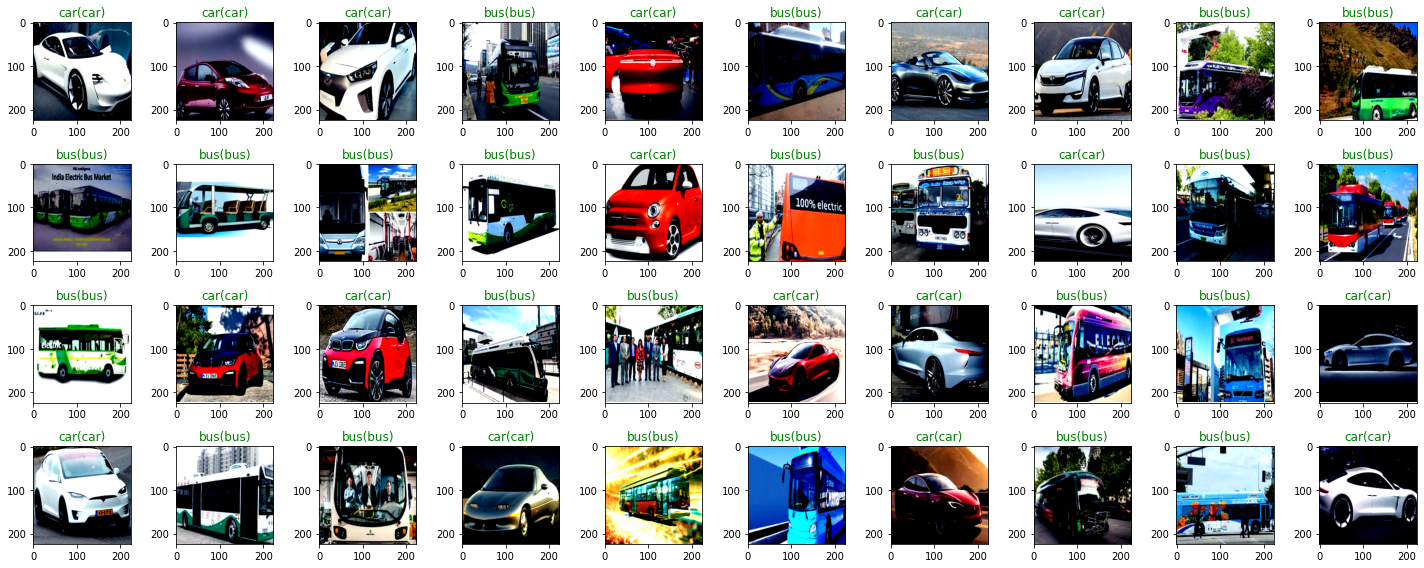

In [6]:
dataset_classes = ['bus','car']

def imshow(imgnumpy: np.ndarray, label, denormalize=False):
    plt.imshow(tensor_to_imgnumpy(imgnumpy,denormalize=denormalize))
    plt.title(dataset_classes[label])

dataset_test = datasets.ImageFolder(root='./dataset/test/', transform=model.tf_compose)
loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

plt.figure(figsize=(20, 8))
for idx,(img,label) in enumerate(loader):
    plt.subplot(4,10,idx+1)
    imshow(img[0],label,denormalize=True)
    
    # inference
    pred =  model.forward(img)

    title_dataset = dataset_classes[label]
    title_pred = dataset_classes[pred.argmax()]
    plt.title(f"{title_dataset}({title_pred})",color=("green" if title_dataset==title_pred else "red"))
    
    if idx == 40-1:
        break
        
plt.tight_layout()

# GRAD-CAM

Let's prepare an image to be processes. Recall that we don't need to retrain the model again, which is a good thing. 

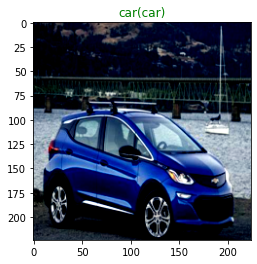

In [7]:
img, label = next(iter(loader))

# inference
pred =  model.forward(img)

title_dataset = dataset_classes[label]
title_pred = dataset_classes[pred.argmax()]

imshow(img[0],label,denormalize=True)
plt.title(f"{title_dataset}({title_pred})",color=("green" if title_dataset==title_pred else "red"));

For the step-by-step process you can refer to https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82, which refers to https://arxiv.org/pdf/1610.02391.pdf 

First you need to do backward prop with respect to the highest logit.


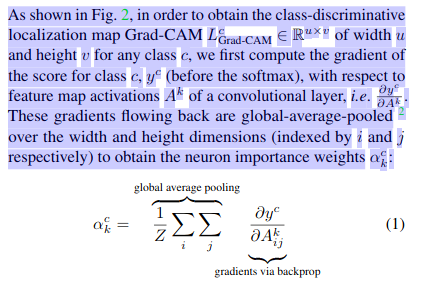


In [8]:
pred[:,pred.argmax()].backward()

# pull the gradients out of the model
gradients = model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

Next, we compute the weighted combination as shown below.

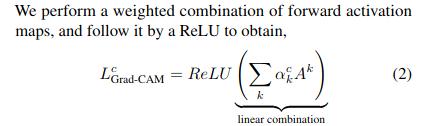


In [9]:
# get the activations of the last convolutional layer
activations = model.get_activations(img).detach() # --> denoted by A^k

# weight the channels by corresponding gradients
for i in range(256): # 256 is the dimension size at dim=1
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze() # --> denoted by L^c_{Grad-CAM}

# relu on top of the heatmap
heatmap = np.maximum(heatmap, 0)

Visualize the heatmap

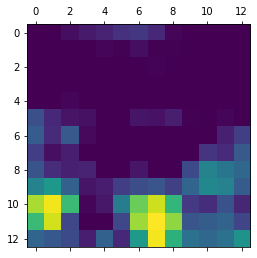

In [10]:
# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

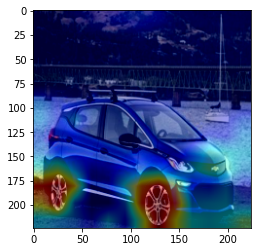

In [11]:
# Combine the two images

imgnumpy = img[0].numpy().transpose(1,2,0)
imgnumpy = imgnumpy*np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.22))
imgnumpy = imgnumpy.clip(0, 1)
imgnumpy = np.uint8(255*imgnumpy)
heatmap_resized = cv.resize(heatmap.detach().numpy(), (imgnumpy.shape[0], imgnumpy.shape[1]))

heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv.applyColorMap(heatmap_resized, cv.COLORMAP_JET)
heatmap_resized = cv.cvtColor(heatmap_resized, cv.COLOR_BGR2RGB)
superimposed_img = np.uint8(heatmap_resized * 0.4 + 0.6*imgnumpy)

plt.imshow(superimposed_img)

You can expect that the heatmap is hot at the locations where the significant features of an object is place, e.g., wheels, lamps, windows, etc.


Lastly, there is a GRAD-CAM library for pytorch (https://pypi.org/project/pytorch-gradcam/).